In [221]:
import torch
import torch.nn as nn

In [222]:
from importlib import reload

In [223]:
import libmotivation
reload(libmotivation)
from libmotivation import *


In [224]:
user_list = get_users_with_choose_difficulty()

In [225]:
user_to_difficulty_items = {}
for user in user_list:
  user_to_difficulty_items[user] = get_choose_difficulty_items_for_user(user)

In [320]:
import arrow
from dateutil import tz

#timezone_list = list(timezone_set)
#print(timezone_list)
#print(list(map(to_hours_and_minutes, timezone_list)))

def parse_timezone_offset(datestr):
  date_parts = datestr.split(' ')
  for x in date_parts:
    if 'GMT' in x:
      output = (x.replace('GMT', ''))
      #timezone_set.add(output)
      return output
  raise Exception(datestr)

def to_hours_and_minutes(offset):
  if len(offset) != 5:
    raise Exception(offset)
  sign = offset[0]
  hours = int(offset[1:3])
  minutes = int(offset[3:])
  if sign == '+':
    return hours,minutes
  if sign == '-':
    return -hours,-minutes
  raise Exception(offset)

def adjust_timestamp_to_timezone_offset(timestamp, offset):
  hours,minutes = to_hours_and_minutes(offset)
  #print(hours, minutes)
  ar = arrow.get(timestamp / 1000.0)
  return ar.shift(hours=hours, minutes=minutes)

def get_time_adjusted_for_timezone(timestamp, datestr):
  offset = parse_timezone_offset(datestr)
  return adjust_timestamp_to_timezone_offset(timestamp, offset)

#print(adjust_timestamp_to_timezone(1548789649098.0,'-0600')) # 'Tue Jan 29 2019 13:20:49 GMT-0600 (Central Standard Time)',
print(get_time_adjusted_for_timezone(1548789649098.0, 'Tue Jan 29 2019 13:20:49 GMT-0600 (Central Standard Time)'))

2019-01-29T13:20:49.098000+00:00


In [289]:


timezone_set = set()



timestamp_server = 1544629175088.0
timestamp_local = 1544629174633.0
#(timestamp_local - timestamp_server) / (1000*3600)
#arrow.get(timestamp_local / 1000)
#timestamp
#arrow.get('Wed Dec 12 2018 07:39:34 GMT-0800 (Pacific Standard Time)')
print(parse_timezone('Wed Dec 12 2018 07:39:34 GMT-0800 (Pacific Standard Time)'))

-0800


In [291]:
for user in user_list:
  difficulty_items = user_to_difficulty_items[user]
  for x in difficulty_items:
    parse_timezone(x['localtime'])

In [306]:
for user in user_list[1000:]:
  difficulty_items = user_to_difficulty_items[user]
  if len(difficulty_items) > 0:
    print(difficulty_items[0])
    break


{'_id': ObjectId('5c50a792f3415400158771ed'), 'url': 'https://www.amazon.com/', 'tab_id': 42, 'session_id': 0, 'is_new_session': True, 'is_preview_mode': False, 'is_suggestion_mode': False, 'is_previously_seen': False, 'type': 'impression', 'intervention': 'internal/choose_difficulty', 'userid': '15182050961fe5b6b51277ac', 'install_id': 'c5bca283a937efd54f195c8a', 'day': 1124, 'synced': 0, 'timestamp': 1548789650566.0, 'localtime': 'Tue Jan 29 2019 13:20:49 GMT-0600 (Central Standard Time)', 'itemid': '9fa7543f0b34fa152d8cd39f', 'log_major_ver': '8', 'log_minor_ver': '1', 'habitlab_version': '1.0.263', 'id': 1, 'logname': 'internal/choose_difficulty', 'timestamp_local': 1548789649098.0}


In [227]:
print(get_most_common_difficulty_for_user('8d2c9eb27dee2dc85bca705b'))

nothing


In [228]:
print(get_most_common_difficulty_overall())

nothing


In [229]:
def get_correctness_of_naive_overall_strategy(user):
  output = {'correct': 0, 'incorrect': 0}
  difficulty_counts = get_choose_difficulty_counts_for_user(user)
  most_common = get_most_common_difficulty_overall()
  if most_common == None:
    return None
  output['total'] = sum(difficulty_counts.values())
  if output['total'] == 0:
    return None
  output['correct'] = difficulty_counts.get(most_common, 0)
  output['incorrect'] = output['total'] - output['correct']
  output['accuracy'] = output['correct'] / output['total']
  return output

In [230]:
def get_correctness_of_naive_peruser_strategy(user):
  output = {'correct': 0, 'incorrect': 0}
  difficulty_counts = get_choose_difficulty_counts_for_user(user)
  most_common = get_most_common_difficulty_for_user(user)
  if most_common == None:
    return None
  output['correct'] = difficulty_counts[most_common]
  output['total'] = sum(difficulty_counts.values())
  output['incorrect'] = output['total'] - output['correct']
  output['accuracy'] = output['correct'] / output['total']
  return output

In [231]:
correctnes_of_naive_per_user = []
for user in user_list:
  correctness_info = get_correctness_of_naive_peruser_strategy(user)
  if correctness_info == None:
    continue
  accuracy = correctness_info['accuracy']
  correctnes_of_naive_per_user.append(accuracy)

print(np.median(correctnes_of_naive_per_user))
print(np.mean(correctnes_of_naive_per_user))

0.6666666666666666
0.7035437782954957


In [232]:
correctnes_of_naive_per_user = []
for user in user_list:
  correctness_info = get_correctness_of_naive_overall_strategy(user)
  if correctness_info == None:
    continue
  accuracy = correctness_info['accuracy']
  correctnes_of_naive_per_user.append(accuracy)

print(np.median(correctnes_of_naive_per_user))
print(np.mean(correctnes_of_naive_per_user))

0.3333333333333333
0.4041840943289177


In [233]:
num_correct_unnormalized = 0
num_total_unnormalized = 0
for user in user_list:
  correctness_info = get_correctness_of_naive_overall_strategy(user)
  if correctness_info == None:
    continue
  num_correct_unnormalized += correctness_info['correct']
  num_total_unnormalized += correctness_info['total']
  #accuracy = correctness_info['accuracy']
  #correctnes_of_naive_per_user.append(accuracy)

#print(np.median(correctnes_of_naive_per_user))
#print(np.mean(correctnes_of_naive_per_user_unnormalized))
print(num_correct_unnormalized / num_total_unnormalized)

0.485751398653191


In [234]:
num_correct_unnormalized = 0
num_total_unnormalized = 0
for user in user_list:
  correctness_info = get_correctness_of_naive_peruser_strategy(user)
  if correctness_info == None:
    continue
  num_correct_unnormalized += correctness_info['correct']
  num_total_unnormalized += correctness_info['total']
  #accuracy = correctness_info['accuracy']
  #correctnes_of_naive_per_user.append(accuracy)

#print(np.median(correctnes_of_naive_per_user))
#print(np.mean(correctnes_of_naive_per_user_unnormalized))
print(num_correct_unnormalized / num_total_unnormalized)

0.7220582705696023


In [425]:
#n_features = 4 # the choice at each step. nothing, easy, medium, hard
#n_features = 5
n_features = 4 + 4 + 7 + 5 + 69
n_categories = 4 # the number of categories we are categorizing among. nothing, easy, medium, hard


In [325]:
difficulty_to_idx = {
  'nothing': 0,
  'easy': 1,
  'medium': 2,
  'hard': 3,
}

# def difficulty_to_idx(difficulty):
#   return {
#     'nothing': 0,
#     'easy': 1,
#     'medium': 2,
#     'hard': 3,
#   }[difficulty]

In [416]:
import json

domain_to_productivity = json.load(open('domain_to_productivity.json'))
domain_to_category = json.load(open('domain_to_category.json'))

category_list = list(set(domain_to_category.values()))

domain_to_productivity_idx = {}
domain_to_category_idx = {}
for domain,productivity in domain_to_productivity.items():
  # should we do something about domains where productivity = 0?
  domain_to_productivity_idx[domain] = productivity + 2
domain_to_category_idx = {}
for domain,category in domain_to_category.items():
  # should we do something about domains where category = ''?
  category_idx = category_list.index(category)
  domain_to_category_idx[domain] = category_idx
print(len(set(domain_to_category_idx.values())))
print(len(set(domain_to_productivity_idx.values())))

69
5


In [423]:
def url_to_domain(url):
  #url='https://www.hello.org/bye/'
  domain=url.split('//')[-1].split('/')[0]
  #print (domain)
  return domain

print(url_to_domain('https://www.hello.org/bye/'))

www.hello.org


In [442]:


def make_tensors_for_user(user):
  features = make_features_for_user(user)
  return make_tensors_from_features(features)

# def make_tensor_from_prior_difficulties_list(prior_difficulties):
#   tensor = torch.zeros(len(prior_difficulties), 1, n_features)
#   for idx,difficulty in enumerate(prior_difficulties):
#     difficulty_idx = difficulty_to_idx[difficulty]
#     tensor[idx][0][difficulty_idx] = 1
#   return tensor

def make_tensor_from_chosen_difficulty(chosen_difficulty):
  difficulty_idx = difficulty_to_idx[chosen_difficulty]
  tensor = torch.tensor([difficulty_idx], dtype=torch.long)
  return tensor

def make_tensors_from_features_v1(features):
  output = []
  for feature in features:
    chosen_difficulty = feature['difficulty']
    prior_difficulties = feature['prior_difficulties']
    user = feature['user']
    category_tensor = make_tensor_from_chosen_difficulty(chosen_difficulty)
    feature_tensor = torch.zeros(len(prior_difficulties), 1, n_features) # n_features = 4 in this version
    for idx,difficulty in enumerate(prior_difficulties):
      difficulty_idx = difficulty_to_idx[difficulty]
      feature_tensor[idx][0][difficulty_idx] = 1
    #feature_tensor = make_tensor_from_prior_difficulties_list(prior_difficulties)
    output.append({'user': user, 'chosen_difficulty': chosen_difficulty, 'category': category_tensor, 'feature': feature_tensor})
  return output

def make_tensors_from_features_v2(features):
  output = []
  for feature in features:
    hour = feature['arrow_time'].hour
    chosen_difficulty = feature['difficulty']
    prior_difficulties = feature['prior_difficulties']
    user = feature['user']
    category_tensor = make_tensor_from_chosen_difficulty(chosen_difficulty)
    feature_tensor = torch.zeros(len(prior_difficulties), 1, n_features) # n_features = 1 in this version
    for idx,difficulty in enumerate(prior_difficulties):
      difficulty_idx = difficulty_to_idx[difficulty]
      feature_tensor[idx][0][0] = difficulty_idx
    output.append({'user': user, 'chosen_difficulty': chosen_difficulty, 'category': category_tensor, 'feature': feature_tensor})
  return output

def hour_to_hour_idx_4cat(hour): # hour: 0 to 24
  if 0 <= hour <= 6:
    return 0
  if 6 < hour <= 12:
    return 1
  if 12 < hour <= 18:
    return 2
  if 18 < hour <= 24:
    return 3
  raise Exception(hour)

def make_tensors_from_features_v3(features):
  output = []
  for feature in features:
    hour = feature['arrow_time'].hour
    hour_idx = hour_to_hour_idx_4cat(hour)
    weekday_idx = feature['arrow_time'].weekday()
    chosen_difficulty = feature['difficulty']
    prior_difficulties = feature['prior_difficulties']
    user = feature['user']
    category_tensor = make_tensor_from_chosen_difficulty(chosen_difficulty)
    feature_tensor = torch.zeros(len(prior_difficulties), 1, n_features) # n_features = 15 in this version
    for idx,difficulty in enumerate(prior_difficulties):
      difficulty_idx = difficulty_to_idx[difficulty]
      feature_tensor[idx][0][difficulty_idx] = 1
      feature_tensor[idx][0][4 + hour_idx] = 1
      feature_tensor[idx][0][8 + weekday_idx] = 1
    output.append({'user': user, 'chosen_difficulty': chosen_difficulty, 'category': category_tensor, 'feature': feature_tensor})
  return output

def make_tensors_from_features_v4(features):
  output = []
  for feature in features:
    url = feature['url']
    domain = url_to_domain(url)
    have_productivity_idx = False
    if domain in domain_to_productivity_idx:
      domain_productivity_idx = domain_to_productivity_idx[domain]
      have_productivity_idx = True
    else:
      domain_productivity_idx = None
    have_category_idx = False
    if domain in domain_to_category_idx:
      domain_category_idx = domain_to_productivity_idx[domain]
      have_category_idx = True
    else:
      domain_category_idx = None
    hour = feature['arrow_time'].hour
    hour_idx = hour_to_hour_idx_4cat(hour)
    weekday_idx = feature['arrow_time'].weekday()
    chosen_difficulty = feature['difficulty']
    prior_difficulties = feature['prior_difficulties']
    user = feature['user']
    category_tensor = make_tensor_from_chosen_difficulty(chosen_difficulty)
    feature_tensor = torch.zeros(len(prior_difficulties), 1, n_features) # n_features = 15 in this version
    for idx,difficulty in enumerate(prior_difficulties):
      difficulty_idx = difficulty_to_idx[difficulty]
      feature_tensor[idx][0][difficulty_idx] = 1
      feature_tensor[idx][0][4 + hour_idx] = 1
      feature_tensor[idx][0][4 + 4 + weekday_idx] = 1
      if have_productivity_idx:
        feature_tensor[idx][0][4 + 4 + 7 + domain_productivity_idx] = 1
      if have_category_idx:
        feature_tensor[idx][0][4 + 4 + 7 + 5 + domain_category_idx] = 1
    output.append({'user': user, 'chosen_difficulty': chosen_difficulty, 'category': category_tensor, 'feature': feature_tensor})
  return output

make_tensors_from_features = make_tensors_from_features_v4

history_length = 10

def make_features_for_user(user):
  output = []
  difficulty_items = get_choose_difficulty_items_for_user(user)
  prior_difficulties = []
  for item in difficulty_items:
    if 'is_random' in item and item['is_random'] == True:
      continue
    if 'type' not in item:
      continue
    if item['type'] != 'action':
      continue
    if 'difficulty' not in item:
      continue
    difficulty = item['difficulty']
    output.append({'url': item['url'], 'user': user, 'difficulty': difficulty, 'prior_difficulties': prior_difficulties[:], 'arrow_time': get_time_adjusted_for_timezone(item['timestamp_local'], item['localtime'])})
    prior_difficulties.append(difficulty)
    if len(prior_difficulties) > history_length:
      prior_difficulties = prior_difficulties[-history_length:]
  return output


In [429]:
print(arrow.get().shift(hours=-8, days=-4).weekday())

6


In [431]:
print(make_tensors_from_features([{'url': 'facebook.com', 'user': 'foobar', 'difficulty': 'easy', 'prior_difficulties': [], 'arrow_time': arrow.get().shift(hours=-8)}]))
print(make_tensors_from_features([{'url': 'facebook.com', 'user': 'foobar', 'difficulty': 'easy', 'prior_difficulties': ['easy', 'nothing'], 'arrow_time': arrow.get().shift(hours=-8)}]))


[{'user': 'foobar', 'chosen_difficulty': 'easy', 'category': tensor([1]), 'feature': tensor([], size=(0, 1, 89))}]
[{'user': 'foobar', 'chosen_difficulty': 'easy', 'category': tensor([1]), 'feature': tensor([[[0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [432]:
all_data = []
for user in user_list:
  print(user)
  tensors = make_tensors_for_user(user)
  for tensor in tensors:
    all_data.append(tensor)

e0ea34c81d4b50cddc7bd752
d45b8b82dec8ec3c591fdbd7
f4d95006c663a799d9185576
8d2c9eb27dee2dc85bca705b
4a5f492c987b873871be4c12
78cc8c70b8be7412e00a1575
04c7fb2ae3098eab5ae390b8
8642884bd204eafc660a04a2
9ca53f1f33ac3e25c2e3f3d2
6e055258e3625ab1db57f0fa
9c00827409f8c296d67f78b4
687606ae6354d8b707f064ee
57ddb2820db2de361757d21b
af8454409cde73bead9d1071
eccfe39b9019a3f566346399
f32cf25130f6fa751892960e
8f77439cf19de38abfd4a417
3bc557eda64de5ff9d2e6fca
16043b6d098957d10448c009
edc3437cabf565d7a8c2f96c
88550c3144f8e1a6e84e83e2
3bc201cd34fc67185861245e
472a909dcf35ed6f1bc6da82
f45c319882842376492cffa7
150f93e5b7dea556c943813e
93b71831840fb44e554b6e36
cb266f371364b060f117b6a1
4e69f3aebac131196a8f2912
834ab49ae4351c22a1d49c2d
43a6fdadccd61a51caf5b588
968e70f748b83408bf3a9fa3
f6e9666fa6fd68a8ff0e2781
48df425ff6b2910b961070e5
ffdc2b2d686dbf9c8c621b35
42564d59c50078ce37d551e1
9595707af25dc9cf08d162f2
414492408538c282663be78d
8880741c0eb16b95ba062848
cc43e1c331c9d74bf7b00fc6
ae97c36156bb44a178a6519d


8da35e44d84233ec248f4172
33a883006ed5d3235f00978b
928c527e00506a4158cdccfb
b05febd5854b233d269b04e2
71098d5b5fa2c43aca67e72c
b27520836efa5514d7e606a0
8c68857d77921615ec167ca3
b586773da2f5ac24536eeb4f
ce1ef1c40c2bd0dd1e2f3aa2
b120e76e564050b2d0457792
99dfe99b1f4d6fa8cdbb4110
c57b61dbfa89921bf4679013
2fb4052db10fb9e1d796c14f
44c361621083a0c056b029b4
d2a3afc469e10fac6f90a5e5
759798d48ea480cd146738d4
1310cd2f7f35173a9551c8cf
8e2da14192c115ee45870d0c
4bebe3f9d6a73dcfa0ba288e
f2ca89d4971eba6f0a2b4da7
b02ec08559176d815a86c29c
f0b3d19bb278c0334accee9f
f4777b7e5d213643f6f7be96
6584dc6e6039cf7bc6a65d78
fb9a51627e26f2af8dab5dc8
4c849873e044b007b91f7f39
90440b09cd2c17ca7784f21d
572a93aa3041afcab9c816e2
b570d0d6f46f095ccdd24376
40b957b71fcc72d41866e6b8
3056a2d989be02294adab708
0038a28ca863a4f560d099e0
63b6228a68cbc5f3597e9743
92202175520ab67835acedff
78cb68240cb3a717a5d6fa31
480015300ad3d0c4520023f2
48c5e9231f6e69e87f68009d
c4bddbc8daa7eaaf6711bf71
de0f8a6433da584c0fa066f3
77d96358edb2978a0899bfcc


9d14195bae7976d99c743bde
302a6630c2a7269db7303c2e
83d1b05e8acb0fb0984e8db7
8eec8af6498d29e87323fd9e
c595e6759c26aa7f898a637d
6de6cf27c09af8b136a6a950
e3d650eb237f5dfca22f1835
0bc3e78c4ecd05a6573836a6
e1db0b6bb8cdc2a6a6879b48
319647af484aacc0d5fabc7d
2cc11117ba44aa9f0dec69a1
dd255758943abf38102497dc
243ea8620fd06631645f326a
22e9433a1d7be8a0dae6ea9c
bbf13fd8b25105f117b3c931
d1c5ef05d3adcfb188344a24
490c823ad1e5e87573af0615
5d553942942322c5fce88a96
1c499412ea5b034f2d45e0fe
a6a4b8327878e0849f128028
39142cdc607dc59a7bc1b095
f7bc103e54d34c39fe4f34bd
63246bd51af632966de41ff5
2b094a50ccfbe785e2ab83a9
c26b116cdec7c37ff5dfc612
cdc94c551609bd8a8c26b624
b83f7d5ff4c3695712f94f3b
75d2f3897e1f41b7f1a9f584
49d39fa16572b1652523d87e
85d88b9d04b7c08dd3ad0c11
8e9a3e1717d60f22873441b6
ac5db577f6903de2b1742f1a
5b30481359252552b9dde0fb
a0d5dad7a6149744236f0d12
f59bfe48cbe62d84b67a6342
2371a488fcceec7a4d4f39c8
2df5bba93a8061846ef8df22
42b989a6aa5f4ca2c34f57d9
428d7d492e9ac130032911ad
d8dc3a0d6a7ebf2ec16d067a


1e36759d62b51ee55127e3ea
475e889d20140acc374dc8df
9457cef4b3bde71691a23e27
0576e33e9656e70e42809000
53c0fea8a3fe5fba4ebda953
974ce09b370f04eb60cca20c
672ee80648388a96a496c67a
13fa72924b5f4e242b79ea98
e0c2d589a97e54d104aaf20f
c360bda9083464a313c3d433
29c9ecdd69f93e2fd3da2901
c9337b5331942cc77a1dcb5d
d9663de4d0124faa17426389
28ae4bcee9e60f01e2ff592a
4cbcece86b63558a939b1195
bf915c3007979242bde4c39c
2bc37f68bc25090ca616dad3
f675a200db9e395a0d9664c1
56306df6e1b7069210a9a9aa
f2b7b18eee41f36c4378d68f
b1176f621b5dbdcdc00e2603
131b8588bce3f9496dd7a766
44e1491ea993238234ffb95b
6c2584797ff3e54db977f190
e84ebcbdece5a606a5177097
6fa1251b3247ad735045d133
2630dcf65f95d2ede589c5f6
51635b984ff479a475421d01
f12f63a378a8ce4a1f9e856b
bff440437a5be8e0c175aaf0
9da1d823cec91d3780cbceb2
6751d267a976e214e678b276
44ba0161172ec028af754247
b104f0690eb75c9b284157a3
fce645da940c68947a2865bb
db4815bf423993303baf4a31
d5bedf70921c6159855d6c56
e48b57bc484668fd268fc877
8c8129e93451e4194b8a0705
e901e68c5a9e04b80a111da7


1b8271ad47904753d9d1e4b3
a63d4eaa8130dc9f7cf02b28
685eda0aace01fb1b837961b
769b4a8de599c811ca3c675e
77fc8bafae1999b7a9655b12
1445a0ad4e81dd0fb0dd6ab0
7b9e8dbff3f63f37ab350362
52478eb3507fdbe26e853d7e
718e38a1c1e6be92f2e74102
fe8617699867551114fc5c63
cb8cb14f9788b83740c86493
2c517d0c479d6c2ae26219a8
4c77b649e0ce8234ad70fbd5
f6b8fcf548ab0fbe0e4b8c8e
f0cc84fcaa742781ac5820f0
2e2f56108dfcf590742d91cd
b5c7e2ab8aa309e0ba44442d
9bb0ee2aa64e7baec92e82f7
629f24f944bdf98f86b8d773
fde1797b33f767bfb4ac7952
5ff9048eab137827fa446740
f92ad8a7c49dc93349aebc69
982078b73e120a8ec0283118
3e449d9e7143f94ed66eebe1
726c92ca624b2fd99a8acdfa
7d1c844cdcbfa6485120d835
0d2483d57c8f634692dbe9c3
d325f40561488b5f450e88bf
ddb10214701439713d69df2b
e9c50b332f319416676f35f7
573ac7c691bc33e5fcdb5670
ff66543aecde06d495f8cf74
23ebdbe291c15ce457280ea0
68a49f75f9422acb39c6c6ab
9b4564be30d09eb0ccfde0fd
84cec107f45cb7851b56ebd8
78e5ed8269ebdd6547fbe032
0e5e859214859b5e6383a1cf
97a4d76bdc56abd8ebfbd2b5
2d1ddf6cf9fc49a17cafc303


8d618b1aa47a24688e77d4b0
6ad1f121a66163acfc82e65b
feace09e23b528b974636c2c
3173774ebf7a5dbb40ccfcfd
53a7a26bd76e25b1aacf7dfc
2b927395103008b7cfc918cf
a0a8d9223037e741b16bff96
3f8d50eb6ee4905210e49719
046c62d4db462ad4e699683b
49c84ab4c0c76b72e511f0af
ce39d0f9dc2d4a7dab62d2c2
67e15f0c7d7d36ff0955cfd7
aeaba3cc03f8caec9a01318d
31b5f3e843617e8e7d6b8ea1
060b544d6e420c04e4d0e5cb
d5f13f439a61a2ea4c2da53f
a29207ac97c2d8948e7475b8
e9073e5534fa33d99221fd87
6222e1f536a077b4ba3e0e3a
50daf5dd90fd8dcc11cf2055
4b71ae5a8df6a93e134a727b
407d594e401bcb7c97ea5933
e55260efa8c2af952869eed8
efdac606466a000b66240ab4
68cf508093482b636339ecb3
45cbe2535dc0d49e8dfefd85
2cb79f08c241bc07d6b60f25
db720e9f1b4a9d5f1c095759
9f4ab612b2b78dbe9c6f8314
34f88479588760b0f7602963
a80090ce7639f13a8cf1850f
d1f9414b5472678a6c48f2a2
2f470b7720f9088bfb180677
7fcd032f6f9f3ea6278fe7cc
81961ca030be6bf624ded76c
38e0272cde4d060a9c84558f
46023821f3049a8e3cb99a12
a90c8d1d8261b89a8120c380
476560f347630b9767305ce4
0ea34aa8bda116179b6069b9


In [433]:
def tensor_to_difficulty(tensor):
  difficulty_idx = tensor[0].data.cpu().numpy()
  return ['nothing', 'easy', 'medium', 'hard'][difficulty_idx]

print(make_tensor_from_chosen_difficulty('hard'))
print(tensor_to_difficulty((make_tensor_from_chosen_difficulty('hard'))))

tensor([3])
hard


In [435]:
training_data = all_data[:int(math.floor(len(all_data)*9/10))]
dev_and_test_data = all_data[len(training_data):]
dev_data = dev_and_test_data[:int(math.floor(len(dev_and_test_data)/2))]
test_data = dev_and_test_data[len(dev_data):]

def randomTrainingExample():
  data = random.choice(training_data)
  category = tensor_to_difficulty(data['category'])
  return category,data['category'],data['feature']


In [436]:
criterion = nn.NLLLoss()


In [437]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden().cuda()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [438]:
torch.cuda.device_count()

1

In [439]:

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_features, n_hidden, n_categories).cuda()

In [440]:
def categoryFromOutput(output):
  top_n,top_i = output.topk(1)
  category_i = top_i[0].item()
  return ['nothing','easy','medium','hard'][category_i],category_i
print(output.topk(1))
print(categoryFromOutput(output))

(tensor([[-0.0455]], device='cuda:0', grad_fn=<TopkBackward>), tensor([[0]], device='cuda:0'))
('nothing', 0)


In [443]:
import time
import math
import random

n_iters = 100000
print_every = 1000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category,category_tensor, line_tensor = randomTrainingExample()
    if line_tensor.size()[0] == 0:
      continue
    output, loss = train(category_tensor.cuda(), line_tensor.cuda())
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

1000 1% (0m 3s) 0.0280 / nothing ✓
2000 2% (0m 6s) 0.0491 / nothing ✓
3000 3% (0m 8s) 0.0060 / nothing ✓
4000 4% (0m 11s) 0.0426 / nothing ✓
5000 5% (0m 14s) 0.3459 / nothing ✓
6000 6% (0m 17s) 0.0161 / nothing ✓
7000 7% (0m 20s) 0.0119 / easy ✓
8000 8% (0m 23s) 0.0442 / easy ✓
9000 9% (0m 26s) 0.0296 / nothing ✓
10000 10% (0m 29s) 0.0258 / nothing ✓
11000 11% (0m 33s) 0.0201 / nothing ✓
12000 12% (0m 37s) 0.0916 / easy ✓
13000 13% (0m 40s) 0.0531 / nothing ✓
14000 14% (0m 44s) 0.9118 / hard ✗ (nothing)
15000 15% (0m 47s) 0.0302 / nothing ✓
16000 16% (0m 51s) 0.0131 / nothing ✓
17000 17% (0m 54s) 0.0377 / easy ✓
18000 18% (0m 58s) 0.0078 / nothing ✓
19000 19% (1m 2s) 0.1155 / nothing ✓
20000 20% (1m 5s) 0.0142 / hard ✓
21000 21% (1m 9s) 1.3240 / nothing ✗ (easy)
22000 22% (1m 12s) 0.0325 / easy ✓
23000 23% (1m 15s) 0.0084 / nothing ✓
24000 24% (1m 18s) 0.0834 / easy ✓
25000 25% (1m 21s) 0.0128 / nothing ✓
26000 26% (1m 24s) 0.0239 / nothing ✓
27000 27% (1m 26s) 0.0123 / nothing ✓
28000

In [444]:
%matplotlib inline


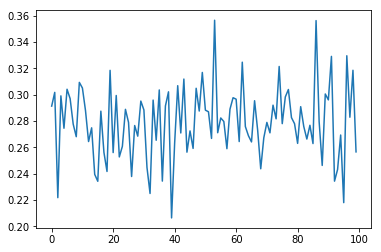

In [456]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
#plt.plot(all_losses[:10])
plt.plot(all_losses)

In [446]:
all_categories = ['nothing', 'easy', 'medium', 'hard']

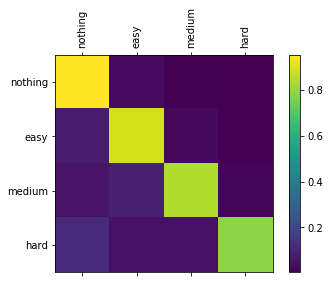

In [447]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden().cuda()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, category_tensor, line_tensor = randomTrainingExample()
    if line_tensor.size()[0] == 0:
      continue
    output = evaluate(line_tensor.cuda())
    guess, guess_i = categoryFromOutput(output)
    category_i = difficulty_to_idx[category]
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [448]:
#print(dev_data[0])

In [449]:
#confusion = torch.zeros(n_categories, n_categories)
num_correct = 0
num_incorrect = 0
confusion = torch.zeros(n_categories, n_categories)

for item in dev_data:
  category_tensor = item['category']
  feature_tensor = item['feature']
  if feature_tensor.size()[0] == 0:
      continue
  difficulty = tensor_to_difficulty(category_tensor)
  difficulty_idx = difficulty_to_idx[difficulty]
  predicted_tensor = evaluate(feature_tensor.cuda())
  predicted_difficulty,predicted_difficulty_idx = categoryFromOutput(predicted_tensor)
  if predicted_difficulty_idx == difficulty_idx:
    num_correct += 1
  else:
    num_incorrect += 1
  confusion[difficulty_idx][predicted_difficulty_idx] += 1
  #print(predicted_difficulty)
  #print(difficulty)
  #break

print('num correct: ' + str(num_correct))
print('num incorrect: ' + str(num_incorrect))
print('percentage correct: ' + str(num_correct / (num_correct + num_incorrect)))

num correct: 2530
num incorrect: 560
percentage correct: 0.8187702265372169


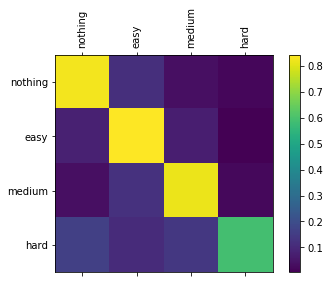

In [450]:
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [451]:
#confusion = torch.zeros(n_categories, n_categories)
num_correct = 0
num_incorrect = 0
confusion = torch.zeros(n_categories, n_categories)

for item in dev_data:
  user = item['user']
  category_tensor = item['category']
  feature_tensor = item['feature']
  if feature_tensor.size()[0] == 0:
      continue
  difficulty = tensor_to_difficulty(category_tensor)
  difficulty_idx = difficulty_to_idx[difficulty]
  predicted_difficulty = get_most_common_difficulty_for_user(user)
  predicted_difficulty_idx = difficulty_to_idx[predicted_difficulty]
  predicted_tensor = make_tensor_from_chosen_difficulty(predicted_difficulty)
  #predicted_tensor = evaluate(feature_tensor.cuda())
  #predicted_difficulty,predicted_difficulty_idx = categoryFromOutput(predicted_tensor)
  if predicted_difficulty_idx == difficulty_idx:
    num_correct += 1
  else:
    num_incorrect += 1
  confusion[difficulty_idx][predicted_difficulty_idx] += 1
  #print(predicted_difficulty)
  #print(difficulty)
  #break

print('num correct: ' + str(num_correct))
print('num incorrect: ' + str(num_incorrect))
print('percentage correct: ' + str(num_correct / (num_correct + num_incorrect)))

num correct: 2508
num incorrect: 582
percentage correct: 0.8116504854368932


In [452]:
def get_most_recent_difficulty(tensor):
  difficulty_arr = list(tensor[-1][0].data.cpu().numpy())
  max_idx = difficulty_arr.index(1)
  return ['nothing', 'easy', 'medium', 'hard'][max_idx]

#confusion = torch.zeros(n_categories, n_categories)
num_correct = 0
num_incorrect = 0
confusion = torch.zeros(n_categories, n_categories)

for item in dev_data:
  user = item['user']
  category_tensor = item['category']
  feature_tensor = item['feature']
  if feature_tensor.size()[0] == 0:
      continue
  difficulty = tensor_to_difficulty(category_tensor)
  difficulty_idx = difficulty_to_idx[difficulty]
  predicted_difficulty = get_most_recent_difficulty(feature_tensor)
  predicted_difficulty_idx = difficulty_to_idx[predicted_difficulty]
  predicted_tensor = make_tensor_from_chosen_difficulty(predicted_difficulty)
  #predicted_tensor = evaluate(feature_tensor.cuda())
  #predicted_difficulty,predicted_difficulty_idx = categoryFromOutput(predicted_tensor)
  if predicted_difficulty_idx == difficulty_idx:
    num_correct += 1
  else:
    num_incorrect += 1
  confusion[difficulty_idx][predicted_difficulty_idx] += 1
  #print(predicted_difficulty)
  #print(difficulty)
  #break

print('num correct: ' + str(num_correct))
print('num incorrect: ' + str(num_incorrect))
print('percentage correct: ' + str(num_correct / (num_correct + num_incorrect)))

num correct: 2489
num incorrect: 601
percentage correct: 0.8055016181229774


In [453]:
#confusion = torch.zeros(n_categories, n_categories)
num_correct = 0
num_incorrect = 0
confusion = torch.zeros(n_categories, n_categories)

for item in dev_data:
  user = item['user']
  category_tensor = item['category']
  feature_tensor = item['feature']
  if feature_tensor.size()[0] == 0:
      continue
  difficulty = tensor_to_difficulty(category_tensor)
  difficulty_idx = difficulty_to_idx[difficulty]
  #predicted_difficulty = get_most_common_difficulty_for_user(user)
  predicted_difficulty = get_most_common_difficulty_overall()
  predicted_difficulty_idx = difficulty_to_idx[predicted_difficulty]
  predicted_tensor = make_tensor_from_chosen_difficulty(predicted_difficulty)
  #predicted_tensor = evaluate(feature_tensor.cuda())
  #predicted_difficulty,predicted_difficulty_idx = categoryFromOutput(predicted_tensor)
  if predicted_difficulty_idx == difficulty_idx:
    num_correct += 1
  else:
    num_incorrect += 1
  confusion[difficulty_idx][predicted_difficulty_idx] += 1
  #print(predicted_difficulty)
  #print(difficulty)
  #break

print('num correct: ' + str(num_correct))
print('num incorrect: ' + str(num_incorrect))
print('percentage correct: ' + str(num_correct / (num_correct + num_incorrect)))

num correct: 1058
num incorrect: 2032
percentage correct: 0.3423948220064725
